# Tensorflow / Keras implementation of [MobileViT](https://arxiv.org/abs/2110.02178)

### Imports

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 12.3 MB/s 


In [3]:
import tensorflow as tf

from keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import numpy as np

In [4]:
patch_size = 4
image_size = 256
image_size_large = 270
expansion_ratio = 2.0
num_classes = 2

### Custom Layers

#### 1. Inverted residual same as MobilenetV2 [paper](https://arxiv.org/abs/1801.04381v4)

In [5]:
class InvertedRes(layers.Layer):
  def __init__(self, expand_channels, output_channels, strides=1):
    super().__init__()
    self.output_channels = output_channels
    self.strides = strides
    self.expand = keras.models.Sequential([
                                          layers.Conv2D(expand_channels, 1, padding="same", use_bias=False),
                                          layers.BatchNormalization(),
                                          layers.Activation('swish')
                                        ], name="expand")
    self.dw_conv = keras.models.Sequential([
                                          layers.DepthwiseConv2D(3, strides=strides, padding="same", use_bias=False),
                                          layers.BatchNormalization(),
                                          layers.Activation('swish')
                                        ], name="depthwise")
    self.pw_conv = keras.models.Sequential([
                                          layers.Conv2D(output_channels, 1, padding="same", use_bias=False),
                                          layers.BatchNormalization(),
                                        ], name='pointwise')
  
  def call(self, x):
    o = self.expand(x)
    o = self.dw_conv(o)
    o = self.pw_conv(o)
    if self.strides == 1 and o.shape[-1] == self.output_channels:
      return o + x
    return o

#### 2. Generic Fully Connected MLP




In [6]:
class FullyConnected(layers.Layer):
  def __init__(self, hidden_units, dropout_rate):
    super().__init__()
    l = []
    for units in hidden_units:
      l.append(layers.Dense(units, activation=tf.nn.swish))
      l.append(layers.Dropout(dropout_rate))
    self.mlp = keras.models.Sequential(l)

  def call(self, x):
    return self.mlp(x)

### **Transformer in **action****



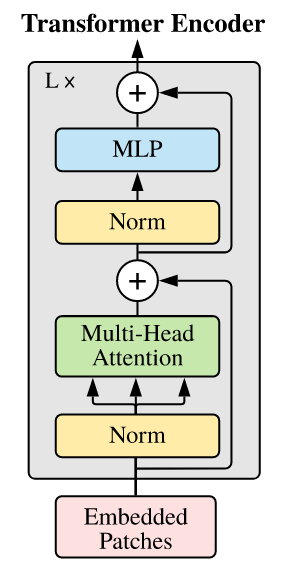

In [7]:
class Transformer(layers.Layer):
  def __init__(self, projection_dim, heads=2):
    super().__init__()
    self.norm1 = layers.LayerNormalization(epsilon=1e-6)
    self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim=projection_dim, dropout=0.1)
    self.norm2 = layers.LayerNormalization(epsilon=1e-6)
  
  def build(self, input_shape):
    self.mlp = FullyConnected([input_shape[-1] * 2, input_shape[-1]], dropout_rate=0.1)


  def call(self, x):
    x1 = self.norm1(x)
    att = self.attention(x1, x1)
    x2 = x + att
    x3 = self.norm2(x2)
    x3 = self.mlp(x3)
    return x3 + x2

### 4. **MobileVit Block**




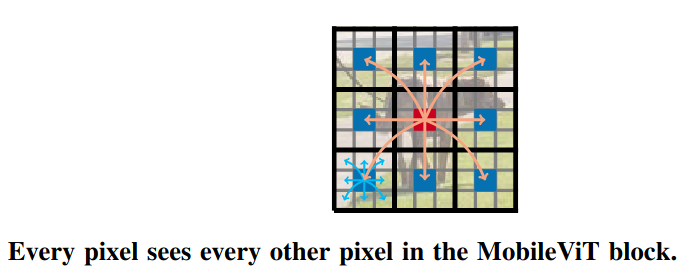

In [8]:
class MobileVitBlock(layers.Layer):
  def __init__(self, num_blocks, projection_dim, strides=1):
    super().__init__()
    self.projection_dim = projection_dim
    self.conv_local = keras.models.Sequential([
                                           layers.Conv2D(projection_dim, 3, padding="same", strides=strides, activation=tf.nn.swish),
                                           layers.Conv2D(projection_dim, 1, padding="same", strides=strides, activation=tf.nn.swish),
                                           ])
    self.transformers = keras.models.Sequential([Transformer(projection_dim, heads=2) for i in range(num_blocks)])
    self.conv_folded = layers.Conv2D(projection_dim, 1, padding="same", strides=strides, activation=tf.nn.swish)
    self.conv_local_global = layers.Conv2D(projection_dim, 3, padding="same", strides=strides, activation=tf.nn.swish)

  def build(self, input_shape):
    num_patches = int((input_shape[1] * input_shape[2]) / patch_size)
    self.unfold = layers.Reshape((patch_size, num_patches, self.projection_dim))
    self.fold = layers.Reshape((input_shape[1], input_shape[2], self.projection_dim))

  def call(self, x):
    local_features = self.conv_local(x)
    patches = self.unfold(local_features)
    global_features = self.transformers(patches)
    folded_features = self.fold(global_features)
    folded_features = self.conv_folded(folded_features)
    local_global_features = tf.concat([x, folded_features], axis=-1)
    local_global_features = self.conv_local_global(local_global_features)
    return local_global_features

### MobileVit Model 

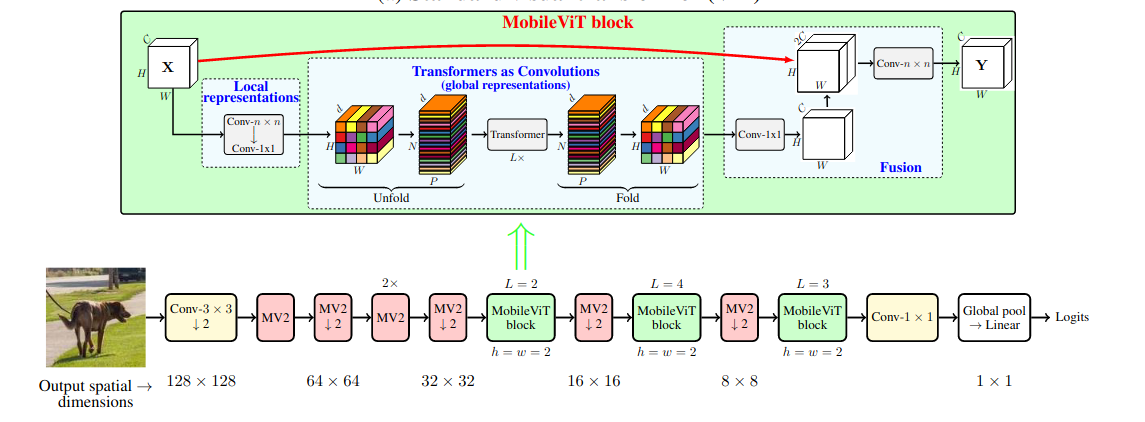

In [9]:
class MobileVit(keras.models.Model):
  def __init__(self, num_classes=num_classes):
    super().__init__()
    self.features = keras.models.Sequential([ layers.Rescaling(scale=1.0 / 255),
                                              layers.Conv2D(16, 3, padding="same", strides=(2, 2), activation=tf.nn.swish),
                                              InvertedRes(16 * expansion_ratio, 16, strides=1),
                                              InvertedRes(16 * expansion_ratio, 24, strides=2),
                                              InvertedRes(24 * expansion_ratio, 24, strides=1),
                                              InvertedRes(24 * expansion_ratio, 24, strides=1),
                                              InvertedRes(24 * expansion_ratio, 48, strides=2),
                                              MobileVitBlock(2, 64, strides=1),
                                              InvertedRes(64 * expansion_ratio, 64, strides=2),
                                              MobileVitBlock(4, 80, strides=1),
                                              InvertedRes(80 * expansion_ratio, 80, strides=2),
                                              MobileVitBlock(3, 96, strides=1),
                                              layers.Conv2D(320, 1, padding="same", strides=(1, 1), activation=tf.nn.swish)
                                            ], name = "features")
    
    self.head = keras.models.Sequential([layers.GlobalAvgPool2D(),
                                         layers.Dense(num_classes, activation="softmax")
                                         ], name="logits")
    
  def call(self, x):
    features = self.features(x)
    logits = self.head(features)
    return logits


In [10]:
model = MobileVit()

In [11]:
model.build((None, 256, 256, 3))

In [12]:
model.summary()

Model: "mobile_vit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (Sequential)       (None, 8, 8, 320)         1344464   
                                                                 
 logits (Sequential)         (None, 2)                 642       
                                                                 
Total params: 1,345,106
Trainable params: 1,342,562
Non-trainable params: 2,544
_________________________________________________________________


### Dataset

In [13]:
def preprocess_train(image, label):
  image = tf.image.resize(image, (image_size_large, image_size_large))
  image = tf.image.random_crop(image, (image_size, image_size, 3))
  image = tf.image.random_flip_left_right(image)
  label = tf.one_hot(label, depth=num_classes)
  return image, label

def preprocess_val(image, label):
  image = tf.image.resize(image, (image_size, image_size))
  label = tf.one_hot(label, depth=num_classes)
  return image, label

def get_dataset(dataset, train=True, bs=64):
    if train:
      dataset = dataset.shuffle(bs * 10)
      dataset = dataset.map(preprocess_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
      dataset = dataset.map(preprocess_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset.batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
train_dataset, val_dataset = tfds.load("cats_vs_dogs", split=["train[:90%]", "train[90%:]"], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteI07XWW/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [15]:
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Train : {num_train}")
print(f"Validation : {num_val}")

train_dataset = get_dataset(train_dataset, train=True)
val_dataset = get_dataset(val_dataset, train=False)

Train : 20936
Validation : 2326


### Train the model

In [ ]:

learning_rate = 0.002
label_smoothing_factor = 0.1
epochs = 30

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_factor)


def run_experiment(epochs=epochs):
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )
    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(val_dataset)
    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")
    return model, history


model, history = run_experiment()


Epoch 1/30
328/328 [==============================] - 501s 1s/step - loss: 0.6334 - accuracy: 0.6571 - val_loss: 0.9362 - val_accuracy: 0.4987
Epoch 2/30
328/328 [==============================] - 474s 1s/step - loss: 0.5839 - accuracy: 0.7192 - val_loss: 1.1201 - val_accuracy: 0.5060
Epoch 3/30
328/328 [==============================] - 474s 1s/step - loss: 0.5587 - accuracy: 0.7447 - val_loss: 0.9140 - val_accuracy: 0.5963
Epoch 4/30
328/328 [==============================] - 474s 1s/step - loss: 0.5107 - accuracy: 0.7877 - val_loss: 0.6835 - val_accuracy: 0.6952
Epoch 5/30
328/328 [==============================] - 474s 1s/step - loss: 0.4673 - accuracy: 0.8222 - val_loss: 0.4407 - val_accuracy: 0.8469
Epoch 6/30
328/328 [==============================] - 474s 1s/step - loss: 0.4423 - accuracy: 0.8386 - val_loss: 0.4508 - val_accuracy: 0.8332
Epoch 7/30
328/328 [==============================] - 473s 1s/step - loss: 0.4130 - accuracy: 0.8621 - val_loss: 0.6187 - val_accuracy: 0.7635